# Tensorflow Setup and Utility Functions

This notebook provides essential functions for setting up a Tensorflow Environment, loading and preprocessing image datasets, and visualizing the data. It's designed to be flexible and adaptable to various directory structures and image formats.

## Imports

- **tensorflow (tf)**: The main library for machine learning operations.
- **numpy (np)**: A library for numerical operations on large, multi-dimensional arrays and matrices.
- **matplotlib.pyplot (plt)**: A library for creating visualizations.
- **seaborn (sns)**: A library for creating more attractive visualizations.
- **pandas (pd)**: A library for data manipulation and analysis.
- **time**: A library for working with time and measuring performance.
- **pathlib.Path**: Provides an object-oriented interface for working with filesystem paths.
- **typing**: A library for type hints and annotations.
- **datetime**: A library for working with dates and times.
- **tqdm**: A library for creating interactive progress bars.
- **sklearn**: A library for machine learning operations.

## GPU Functions

The following functions are used to set up the Tensorflow environment and check for the presence of a GPU.


In [26]:
import time
from datetime import datetime
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.manifold import TSNE
from tqdm import tqdm

### Tensorflow Auxiliary Functinons and Configuration


In [27]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.17.0


In [57]:
tf.keras.mixed_precision.set_global_policy("float32")

In [29]:
def setup_gpu() -> Tuple[tf.distribute.Strategy, int]:
    """
    Set up a GPU strategy for tensorflow.

    This function does the following
    1. Detects available GPUs.
    2. Sets up an appropriate strategy for the available GPUs.
    3. Returns the strategy and number of GPUs available.

    This function handles three cases:
    - No GPUs: returns a default strategy using CPU.
    - Single GPU: returns a MirroredStrategy with a single device.
    - Multiple GPUs: returns a MirroredStrategy with all available devices.

    Returns:
      tuple: (tf.distribute.Strategy, int) where the first element is the strategy and the second element is the number of GPUs available.
    """

    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)

    if num_gpus == 0:
        print(f"No GPUs detected. Running on CPU.")
        return tf.distribute.get_strategy(), 0

    elif num_gpus == 1:
        print(f"1 GPU detected: {gpus[0].name}")
        return tf.distribute.MirroredStrategy(), 1

    else:
        print(f"{num_gpus} GPUs detected: {[gpu.name for gpu in gpus]}")
        return tf.distribute.MirroredStrategy(), num_gpus

In [30]:
def setup_tensorboard():
    """
    Setup a TensorBoard for visualization. To view the TensorBoard, run the following command in the terminal:

    tensorboard --logdir logs/scalars
    """

    logdir = "logs/scalars" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(str(logdir + "/metrics"))
    file_writer.set_as_default()

    print(f"TensorBoard logs will be saved to: {logdir}")

In [31]:
def benchmark_data_pipeline(dataset: tf.data.Dataset):
    """
    Benchmark the data pipeline to ensure efficient data loading.

    Args:
      dataset (tf.data.Dataset): Dataset to benchmark.
    """

    start_time = time.time()
    for _ in tqdm(dataset, desc="Benchmarking data pipeline"):
        pass

    end_time = time.time()
    print(f"Data pipeline benchmark: {end_time - start_time:.2f} seconds")

### Auxiliary Functions


In [32]:
def load_dataset(
    data_path,
    img_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
    validation_split: float = 0.2,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, List[str]]:
    """
    Load and preprocess data using tf.data API.

    Args:
      data_path (str): Path to the data directory.
      img_size (tuple): Image size to resize to.
      batch_size (int): Batch size.
      validation_split (float): Fraction of data to use for validation.

    Returns:
      tuple: (tf.data.Dataset, tf.data.Dataset) where the first element is the training dataset and the second element is the validation dataset.
    """

    data_dir = Path(data_path)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    class_names = train_ds.class_names

    # Performance optimization
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names

In [33]:
def data_augmentaton():
    """
    Creates data augmentation pipeline using tf.keras.Sequential.

    Returns:
      tf.keras.Sequential: A data augmentation model.
    """

    return tf.keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomContrast(0.2),
        ]
    )

### Visualization Functions


In [34]:
def visualize_data_augmentation(
    dataset: tf.data.Dataset, data_augmentation, num_images: int = 3
):
    """
    Visualize the effect of data augmentation on a few images.

    Args:
      dataset (tf.data.Dataset): Dataset to visualize.
      data_augmentation (function): Data augmentation function.
      num_images (int): Number of images to visualize.

    Returns:
      None
    """

    plt.figure(figsize=(10, 5 * num_images))

    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(num_images, 2, 2 * i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Original")
            plt.axis("off")

            ax = plt.subplot(num_images, 2, 2 * i + 2)
            augmented_images = data_augmentation(tf.expand_dims(images[i], 0))
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.title("Augmented")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [35]:
def show_batch(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Display a batch of images from the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to display.
        class_names (list): List of class names.
    """

    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [36]:
def analyze_class_distribution(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Analyze and visualize the class distribution in the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to analyze.
        class_names (list): List of class names.
    """

    class_counts = {name: 0 for name in class_names}
    for _, labels in tqdm(dataset, desc="Analyzing class distribution"):
        for label in labels:
            class_counts[class_names[label]] += 1

    df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
    df = df.sort_values("count", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y=df["count"], data=df)

    plt.title("Class distribution in the dataset")
    plt.xlabel("Class names")
    plt.ylabel("Count")

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [37]:
def visualize_features(
    dataset: tf.data.Dataset, class_names: List[str], num_samples: int = 1000
):
    """
    Visualize high-dimensional features using t-SNE.

    Args:
        dataset (tf.data.Dataset): Dataset to extract features from.
        class_names (list): List of class names.
        num_samples (int): Number of samples to visualize.
    """

    feature_model = tf.keras.applications.MobileNetV2(include_top=False, pooling="avg")

    features, labels = [], []

    for images, batch_labels in tqdm(
        dataset.take(num_samples // 32), desc="Extracting features"
    ):
        batch_features = feature_model(images)
        features.extend(batch_features.numpy())
        labels.extend(batch_labels.numpy())

    features = np.array(features)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=labels,
        palette="tab10",
        legend="full",
        alpha=0.8,
    )

    plt.title("t-SNE visualization of high-dimensional features")
    plt.tight_layout()
    plt.show()

In [38]:
def visualize_model_architecture(model: tf.keras.Model, name: str = "base_model"):
    """
    Visualize the architecture of the model

    Args:
      model: Model to visualize
      name: Name of the model
    """

    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=True,
        show_layer_names=False,
    )

    print("Model architecture visualization saved to base_model_architecture.png")

## Model Creation


### Transfer Learning


In [50]:
def create_base_model(
    input_shape: Tuple[int, int, int] = (224, 224, 3), weights="imagenet"
) -> tf.keras.Model:
    """
    Creates a base model using RestNet50V2 pre-trained on ImageNet.

    Args:
      input_shape (tuple): The shape of the input images (height, width, channels)
      weights (str): The weights to use for the model. 'imagenet' for pre-trained weights,
                     or None for random initialization.

    Returns:
      tf.keras.Model: A RestNet50V2 model.
    """

    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights=weights,
        input_shape=input_shape,
    )

    base_model.trainable = False
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    return tf.keras.Sequential([base_model, global_average_layer])

## Loading everything


### Hyperparameters


In [40]:
EPOCHS: int = 200
BATCH_SIZE: int = 32
IMG_SIZE: Tuple[int, int] = (224, 224)

### Loading the dataset


In [41]:
base_path = "../data/processed/labeled/"

In [42]:
train_ds, val_ds, class_names = load_dataset(base_path, IMG_SIZE, BATCH_SIZE)

Found 812 files belonging to 12 classes.
Using 650 files for training.
Found 812 files belonging to 12 classes.
Using 162 files for validation.


### Showing the data


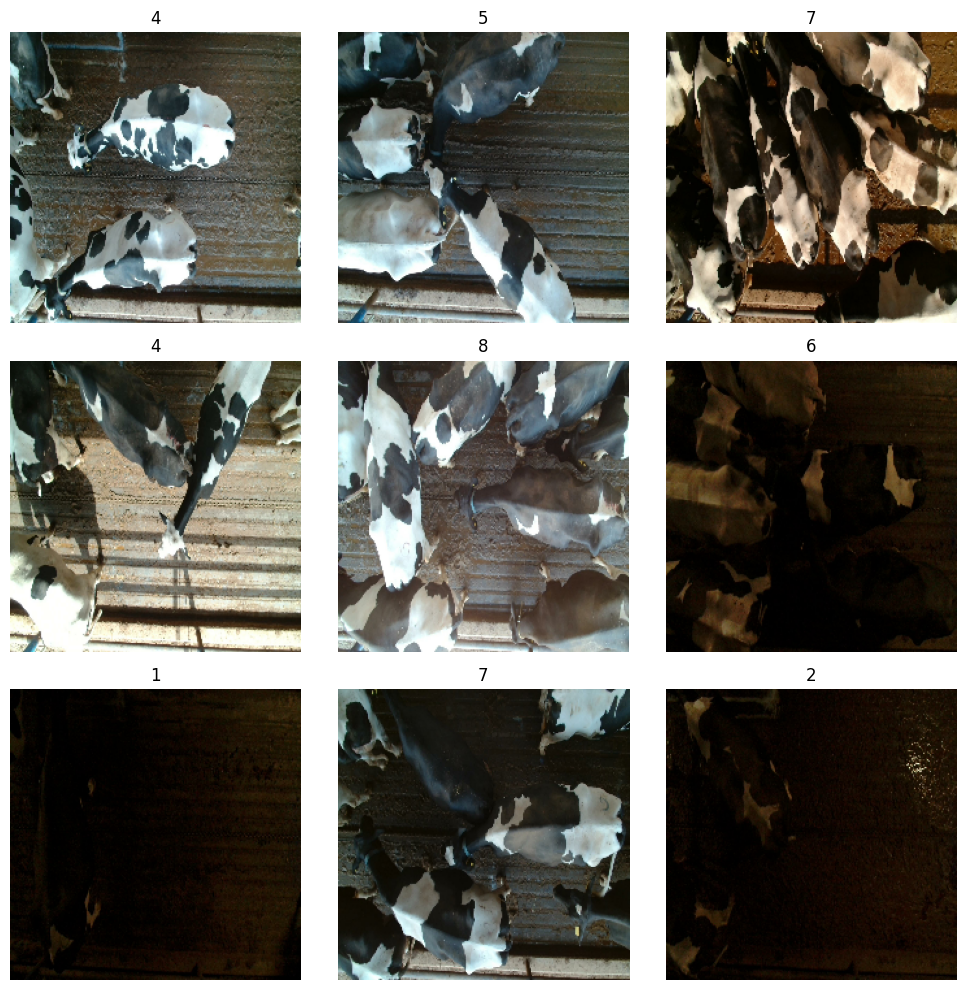

In [43]:
show_batch(train_ds, class_names)

Analyzing class distribution: 100%|██████████| 21/21 [00:00<00:00, 154.13it/s]


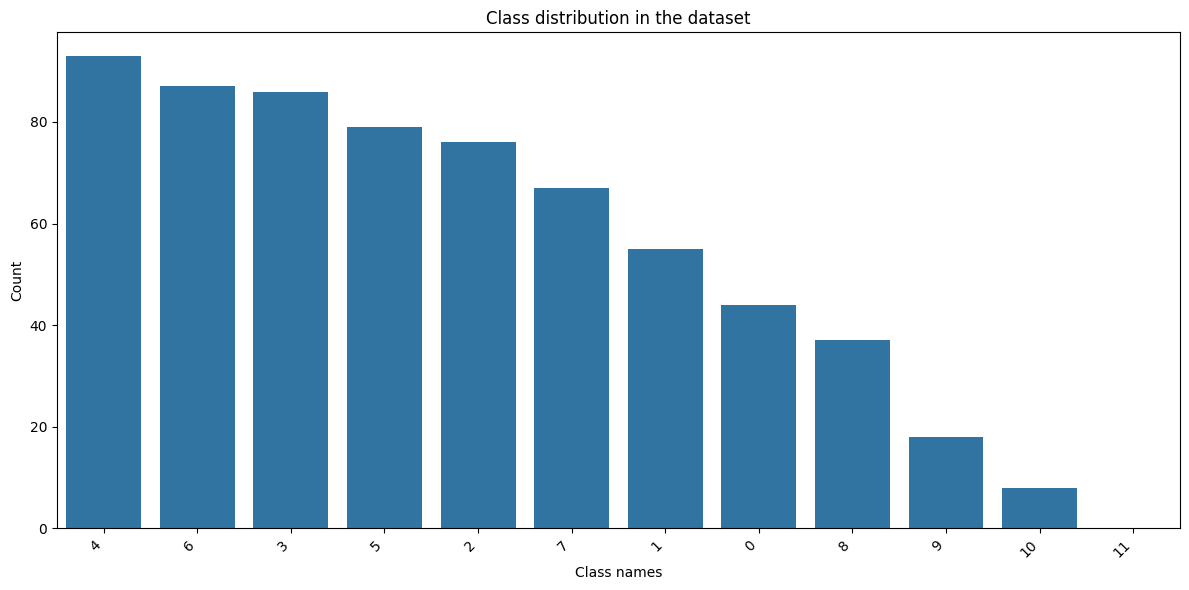

In [44]:
analyze_class_distribution(train_ds, class_names)

2024-10-21 11:02:06.689522: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


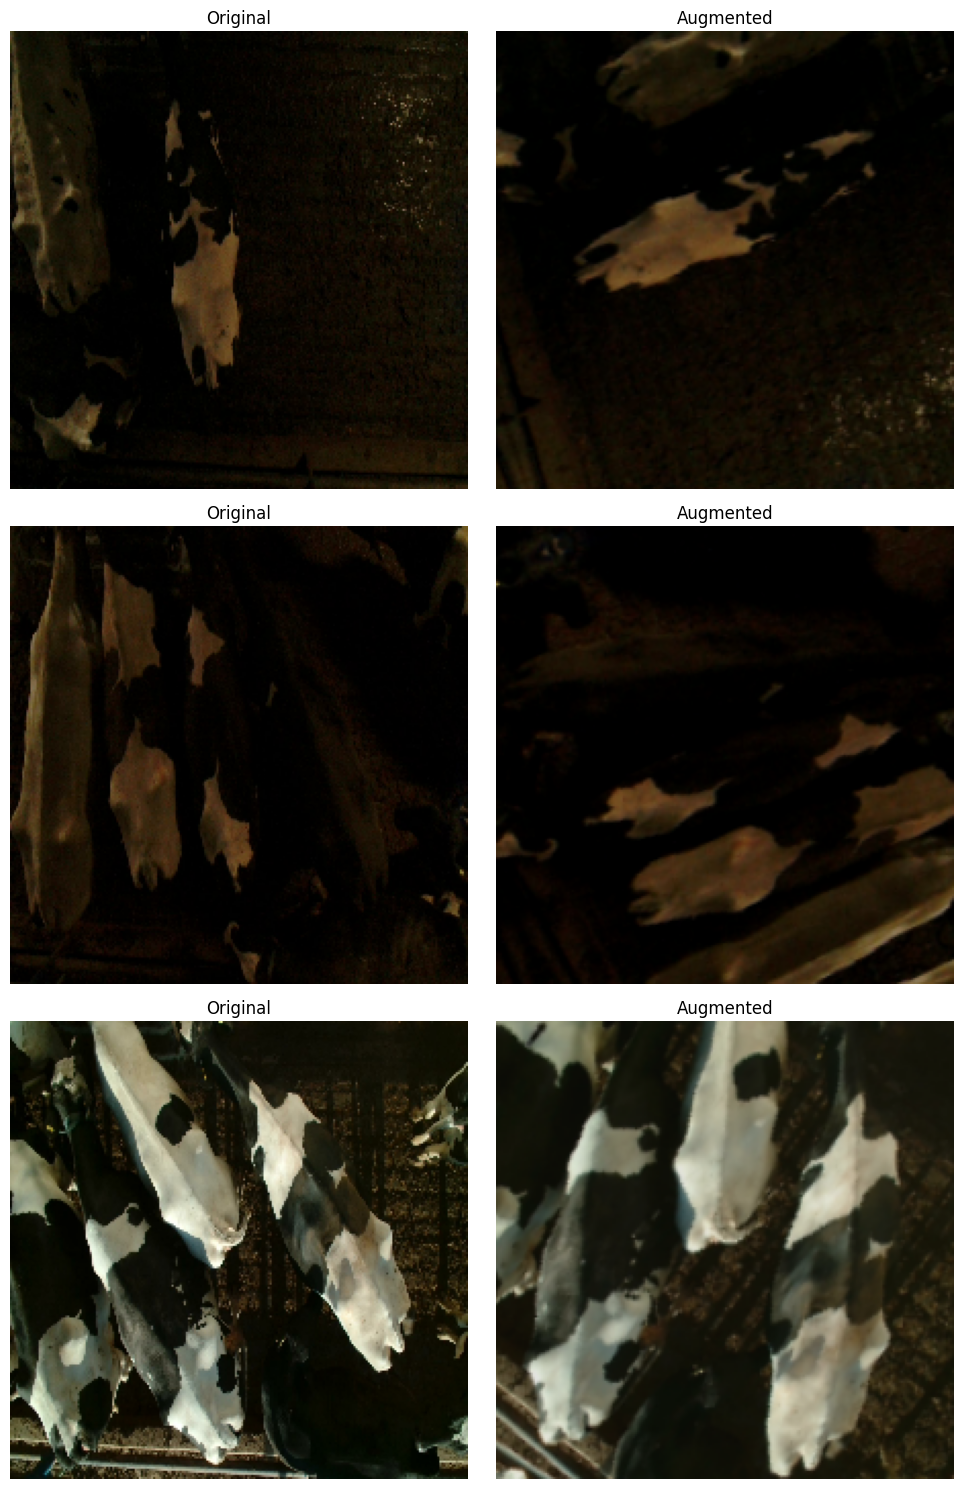

In [45]:
data_augmentaton = data_augmentaton()
visualize_data_augmentation(train_ds, data_augmentaton)

/tmp/ipykernel_6577/2569194551.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  feature_model = tf.keras.applications.MobileNetV2(include_top=False, pooling="avg")
Extracting features: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


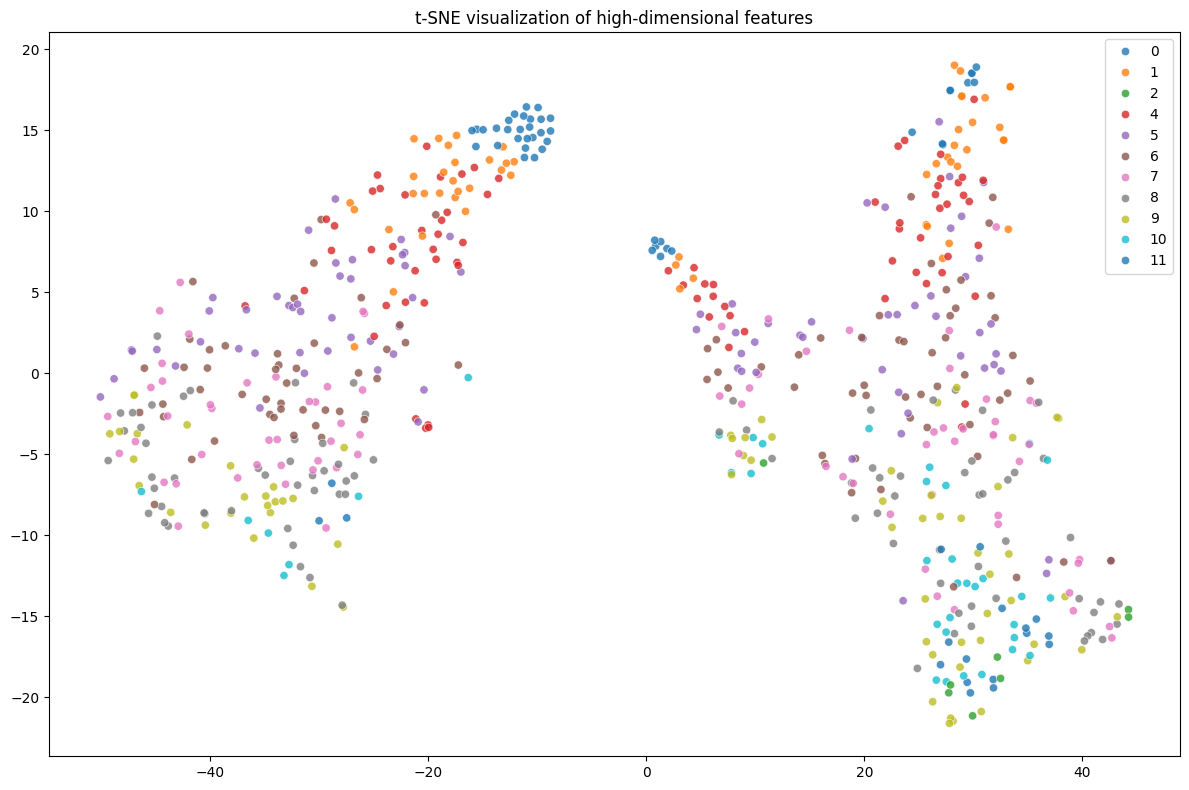

In [46]:
visualize_features(train_ds, class_names)

### Creating the base model


In [51]:
input_shape = train_ds.element_spec[0].shape[1:]
base_model = create_base_model(input_shape)

In [52]:
base_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [55]:
visualize_model_architecture(base_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture visualization saved to base_model_architecture.png


Testing the model with a sample batch to ensure it works


In [56]:
for images, _ in train_ds.take(1):
    output = base_model(images)
    print(f"Output shape: {output.shape}")

Output shape: (32, 2048)
